In [2]:
import sys
import os

notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
project_root = os.path.dirname(project_root)
sys.path.append(project_root)
from data import preprocess, feature_extraction
from visualization import visualize


## Import libraries

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree


## Data preprocessing

In [4]:
# Initialize preprocessing object
pre_proc = preprocess.Preprocessing()

# Read data from CSV file

data = pre_proc.read_CSV('train.csv')
test = pre_proc.read_CSV('test.csv')
# Apply preprocessing to text column
data['processed_text'] = data['text'].apply(pre_proc.preprocess)
test['processed_text'] = test['text'].apply(pre_proc.preprocess)
# View dataset info
data.info()



✓ 'punkt' is already available.
✓ 'stopwords' is already available.
✓ 'wordnet' is already available.
✓ 'averaged_perceptron_tagger' is already available.
<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             27480 non-null  object 
 1   text               27480 non-null  object 
 2   selected_text      27480 non-null  object 
 3   sentiment          27480 non-null  object 
 4   Time of Tweet      27480 non-null  object 
 5   Age of User        27480 non-null  object 
 6   Country            27480 non-null  object 
 7   Population -2020   27480 non-null  int64  
 8   Land Area (Kmï¿½)  27480 non-null  float64
 9   Density (P/Kmï¿½)  27480 non-null  int64  
 10  processed_text     27480 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 2.5+ MB


## Splitting the dataset

In [5]:

vectorizer = TfidfVectorizer()

X_train = data['processed_text']
X_train_vectors = vectorizer.fit_transform(X_train)

X_test = test['processed_text']
X_test_vectors = vectorizer.transform(X_test)

y_train = data['sentiment']
y_test = test['sentiment']


print(f"Number of training samples: {X_train_vectors.shape}")
print(f"Number of test samples: {X_test_vectors.shape}")

Number of training samples: (27480, 25828)
Number of test samples: (3534, 25828)


## Train Decision Tree model

In [6]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_vectors, y_train)

DecisionTreeClassifier()

## Make predictions & evaluate performance

In [7]:
# Making predictions on the test set
y_pred = dt_classifier.predict(X_test_vectors)
y_score= dt_classifier.predict_proba(X_test_vectors)

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute F1-score (weighted to account for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")

print(classification_report(y_test, y_pred))


Accuracy: 0.6553480475382003
F1-score: 0.6555807073393962
              precision    recall  f1-score   support

    negative       0.63      0.64      0.63      1001
     neutral       0.63      0.63      0.63      1430
    positive       0.71      0.70      0.71      1103

    accuracy                           0.66      3534
   macro avg       0.66      0.66      0.66      3534
weighted avg       0.66      0.66      0.66      3534



## Visualization before tuning

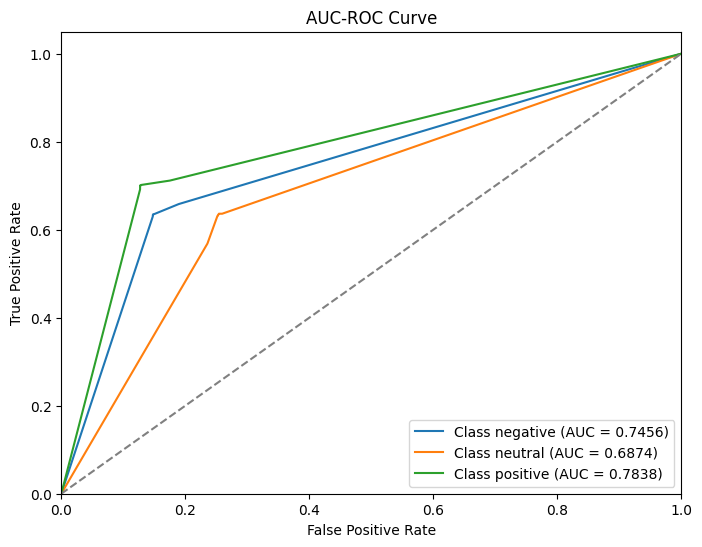

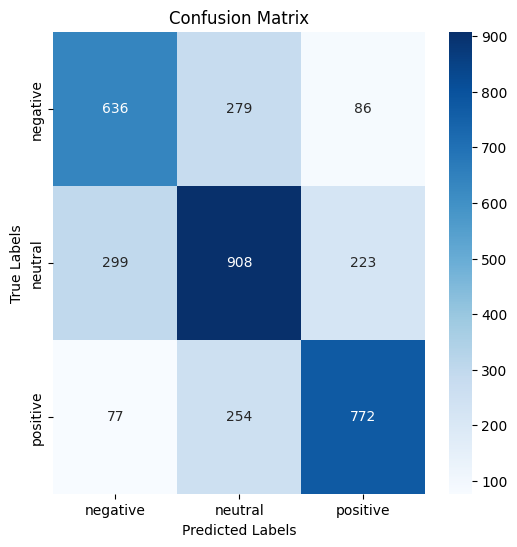

In [8]:
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(y)



label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])
test['label'] = label_encoder.transform(test['sentiment'])

# print(label_encoder.classes_)


   # Plot AUC-ROC Curve
visualize.plot_roc_auc(y_test, y_score, label_encoder.classes_)

    # Plot Confusion Matrix
visualize.plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)

## Decision Tree Post-Pruning

In [9]:
# Cost-complexity pruning (Post-pruning)
path = dt_classifier.cost_complexity_pruning_path(X_train_vectors, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train a series of decision trees with different alpha values
pruned_models = []
for ccp_alpha in ccp_alphas:
    pruned_model = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    pruned_model.fit(X_train_vectors, y_train)
    pruned_models.append(pruned_model)

# Find the model with the best accuracy on test data
best_accuracy = 0
best_pruned_model = None
for pruned_model in pruned_models:
    accuracy = pruned_model.score(X_test_vectors, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pruned_model = pruned_model
# Model Accuracy after pruning
accuracy_after_pruning = best_pruned_model.score(X_test_vectors, y_test)
print("Accuracy after pruning:", accuracy_after_pruning)

Accuracy after pruning: 0.6918505942275043


## Evaluate performance & Visualization after tuning

Accuracy: 0.6918505942275043
F1-score: 0.6914556770016602
              precision    recall  f1-score   support

    negative       0.70      0.61      0.65      1001
     neutral       0.65      0.71      0.68      1430
    positive       0.75      0.75      0.75      1103

    accuracy                           0.69      3534
   macro avg       0.70      0.69      0.69      3534
weighted avg       0.69      0.69      0.69      3534



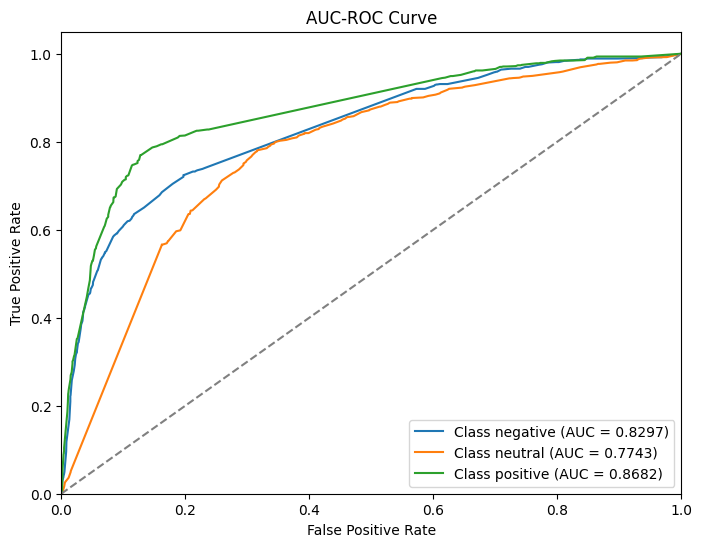

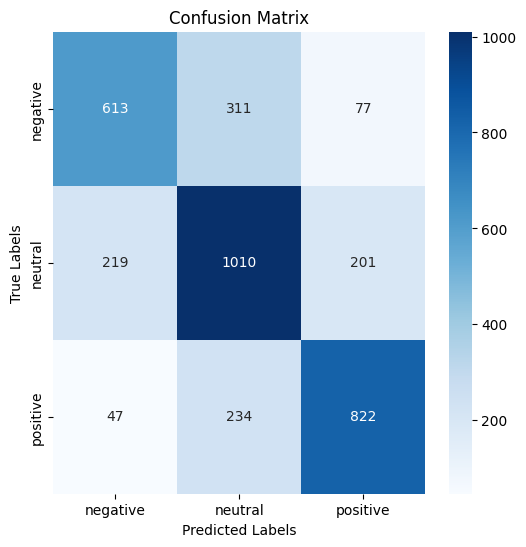

In [11]:
# Making predictions on the test set
y_pred = best_pruned_model.predict(X_test_vectors)
y_score= best_pruned_model.predict_proba(X_test_vectors)
# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute F1-score (weighted to account for class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(classification_report(y_test, y_pred))

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])
test['label'] = label_encoder.transform(test['sentiment'])

   # Plot AUC-ROC Curve
visualize.plot_roc_auc(y_test, y_score, label_encoder.classes_)

    # Plot Confusion Matrix
visualize.plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)